# Setup

## Create Filesystem
This notebook is primarily meant to be executed in Colab as a computational backend. If you want to run on your own hardware with data, you need to set `data_dir` and `ALLOW_IO`

This notebook viewable directly on Colab from [https://colab.research.google.com/github/rcharan/phutball/blob/master/pytorch-implementation/model-training.ipynb](https://colab.research.google.com/github/rcharan/phutball/blob/master/pytorch-implementation/model-training.ipynb) (it is a mirror of github). But if it has moved branches or you are looking at a past commit, look at the [Google instructions](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb) on where to find this file.

The workflow is:
 - Data stored in (my personal/private) Google Drive
 - Utilities/library files (for importing) on github, edited on local hardware and pushed to github.
 - Notebook hosted on github, edited both in Colab or locally (depending on the relative value of having a GPU attached versus being able to use regular Jupyter keyboard shortcuts/a superior interface)

In [1]:
# Attempt Colab setup if on Colab
try:
  import google.colab
except:
  ALLOW_IO = False
else:
  # Mount Google Drive at data_dir
  #  (for data)
  from google.colab import drive
  from os.path import join
  ROOT = '/content/drive'
  DATA = 'My Drive/phutball'
  drive.mount(ROOT)
  ALLOW_IO = True
  data_dir = join(ROOT, DATA)
  !mkdir "{data_dir}"     # in case we haven't created it already   

  # Pull in code from github
  %cd /content
  github_repo = 'https://github.com/rcharan/phutball'
  !git clone -b master {github_repo}
  %cd /content/phutball
  
  # Point python to code base
  import sys
  sys.path.append('/content/phutball/pytorch-implementation')

  # Updater for library functions changed on local hardware and pushed to github
  #  (circuitous, I know)
  def update_repo():
    !git pull

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/My Drive/phutball’: File exists
/content
Cloning into 'phutball'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 2131 (delta 89), reused 79 (delta 45), pack-reused 1984
Receiving objects: 100% (2131/2131), 38.57 MiB | 37.68 MiB/s, done.
Resolving deltas: 100% (1340/1340), done.
/content/phutball


## Imports

In [1]:
%%capture

%load_ext autoreload
%autoreload 2

import os
import gc
import numpy as np

# Codebase
from lib.models.model_v3   import TDConway
from lib.off_policy        import EpsilonGreedy
from lib.optim             import AlternatingTDLambda

from lib.training          import training_loop

from lib.utilities         import config, lfilter
from lib.testing_utilities import create_state, visualize_state, boards
from lib.timer             import Timer

from lib.move_selection    import get_next_move_training


# Graphics for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
plt.ioff()

ModuleNotFoundError: No module named 'lib.timer'

## Device Management Utilities
Setup for GPU, CPU, or (not working well/fully implemented) TPU

In [2]:
import os

def install_tpu():
  VERSION = "1.5"
  !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
  !python pytorch-xla-env-setup.py --version $VERSION
  
use_tpu = 'COLAB_TPU_ADDR' in os.environ

In [3]:
import torch

if use_tpu:
  # Install PyTorch/XLA
  install_tpu()
  import torch_xla
  import torch_xla.core.xla_model as xm
  
  # Set the device
  device = xm.xla_device()
  
  # Memory inspection
  def print_memory_usage():
    print('TPU memory inspection not implemented')
  def print_max_memory_usage():
    print('TPU memory inspection not implemented')
  def garbage_collect():
    gc.collect() # No TPU specific implementation yet
    
elif torch.cuda.is_available():
  # Set the device
  device = torch.device('cuda')
  
  # Echo GPU info
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  print(gpu_info)
  
  # Memory inspection and management
  from lib.memory import (
    print_memory_usage_cuda     as print_memory_usage,
    print_max_memory_usage_cuda as print_max_memory_usage,
    garbage_collect_cuda        as garbage_collect
  )

else:
  # Set the device to CPU
  device = torch.device('cpu')
  
  # Echo RAM info
  from psutil import virtual_memory
  from lib.memory import format_bytes
  ram = virtual_memory().total
  print(format_bytes(ram), 'available memory on CPU-based runtime')
  
  # Memory inspection and management
  from lib.memory import (
    print_memory_usage, 
    print_max_memory_usage,
    garbage_collect
  )

8.00GiB available memory on CPU-based runtime


# Utilities

In [4]:
def save(fname, model):
  state_dict = {
      'model' : model.state_dict(),
  }
  torch.save(state_dict, f'{data_dir}/{fname}.pt')

def fname(version, game_num):
  return f'v{version}-{game_num}'
  
def load(version, game_num, model):
  sd = torch.load(f'{data_dir}/{fname(version, game_num)}.pt')
  model.load_state_dict(sd['model'])
  return model

# Training

## Fit one cycle

In [ ]:
from lib.pretraining.fit_one_cycle import fit_one_cycle

In [ ]:
model = TDConway(config).to(device)
data = fit_one_cycle(model)

6942/6942 [==============================] - 274s 40ms/step


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()

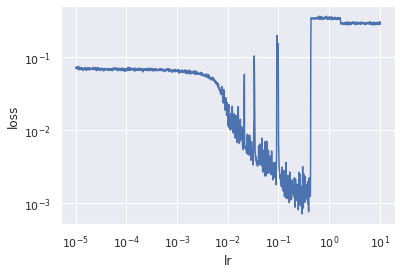

In [ ]:
df = pd.DataFrame(data, columns = ['lr', 'loss'])
df['loss'] = df.loss.apply(lambda l : l.item())
df = df.groupby('lr').mean().reset_index()

fig, ax = plt.subplots()
sns.lineplot(x = 'lr', y='loss', data = df, ax = ax)
ax.set_xscale('log', basex = 10)
ax.set_yscale('log', basey = 10)
fig

## Pretraining

In [6]:
from lib.pretraining.pre_training import pre_train
from torch.optim import SGD

In [ ]:
model = TDConway(config).to(device)
optimizer = SGD(model.parameters(), lr = 0.05)

pre_train(model, optimizer, loops = 40000, batch_size = 300)

17133/40000 [===========>..................] - ETA: 4:55 - loss: 0.0026

In [ ]:
version = '0.4.1'
game_num = 'pre40000x300'

save(fname(version, game_num), model)

## Profile

In [ ]:
from lib.utilities import product

In [ ]:
initial_state = create_state('H10').to(device)
epsilon_greedy = EpsilonGreedy(0.01)

def num_params(model):
  return sum(
      product(t.shape) for t in model.parameters()
  )

In [ ]:
from torch.optim import SGD
# version = '0.3.1'
# game_num = '70000'
model     = TDConway(config, temperature = 0.1).to(device)
model     = load(version, game_num, model)

optimizer = AlternatingTDLambda(model.parameters(), alpha = 0.05, lamda = 0.9)

print(f'{num_params(model):,d} parameters')
%timeit get_next_move_training(initial_state, model, device)
%timeit training_loop(model, optimizer, 1, device, off_policy = epsilon_greedy)
# %prun training_loop(model, optimizer, 1, device, off_policy = epsilon_greedy)

1,935,105 parameters
100 loops, best of 3: 3.28 ms per loop
1/1 [==============================] - 0s 172us/step
1 loop, best of 3: 473 ms per loop


## Train

In [5]:
from datetime import datetime
from pytz import timezone
eastern = timezone('US/Eastern')


In [6]:
epsilon_greedy = EpsilonGreedy(0.05)
model = TDConway(config, temperature = 0.1).to(device)
optimizer = AlternatingTDLambda(model.parameters(), 0.05, 0.9)

version  = '0.4.1'
game_num = 'pre40000x300'

load(version, game_num, model);

In [ ]:
game_num = 0

batch_size = 5000

while True: # Until Colab or User disconnects out of boredom
  try:
    training_loop(model, optimizer, batch_size, device, 
                  off_policy = epsilon_greedy, 
                  verbose = 1,
                  initial = 0.1)
    game_num += batch_size

    save(fname(version, game_num), model)

    print(f'Finished {game_num} games at', datetime.now(eastern).strftime('%I:%M%p %Z'))
  except KeyboardInterrupt:
    break

50000/50000 [==============================] - 459s 9ms/step
Finished 50000 games at 04:25PM EDT
50000/50000 [==============================] - 462s 9ms/step
Finished 100000 games at 04:32PM EDT
50000/50000 [==============================] - 455s 9ms/step
Finished 150000 games at 04:40PM EDT
 2080/50000 [>.............................] - ETA: 7:26

In [ ]:
# Versioning:
#  Major versions - major change in approach
#  Minor versions - incompatible architecture tweaks
#  Build          - retraining or changes in training parameters
#  Game number    - number of games trained or pre{E}x{B} where E is the the
#                   number of batches and B is the batch size for pre-training
# Example: v0.1.2 @400 is the second attempt at training the v0.1 architecture
#  and was trained for 400 games

# Performance benchmarks.
#  GPU benchmarks are on a P100 unless otherwise stated
#    per move    : training-relevant
#    forward pass: evaluation (arena mode) relevant
#  CPU benchmarks are for inference on a fixed set of 300 randomly
#    generated boards on an Intel i5 chipset. (deployment-relevant)
#  Memory consumption has not been an issue

# v0.1: architecture from model_v1. Training: Alternating TD(λ)
#  ~60M params (59,943,809)
#  GPU: 100–110ms/move with 50-60ms for forward pass
#  CPU: 8.1s ± 0.5s 
#  alpha = 0.01, lambda = 0.9, epsilon = 0.1
#
#  - v0.1.1 - don't use, bug in training
#  - v0.1.2 - Use. available @400. Win rate v RandoTron 51% (😢)

# v0.2: architecture from model_v2. Smaller Residual ConvNet (17 layers)
#  Training: Alternating TD(λ) WITH pretraining to prefer the ball to the
#   right on randomly generated boards
#  ~4.4M params (4,381,505)
#  GPU: 30-35ms/move with ~12ms for forward pass
#  CPU: 1.1s ± 0.02s
#
# - v0.2.1 - Available @pre10000x300, @400, @1500, @3500
#          - Hyperparameters same as v0.1
#            Win rate v RandoTron 
#            - @pre-trained: 75.4% ±1.4% (!?)
#            - @400: 49%
#            - @1500: 56.9% ±1.8%
#            - @3500: 54.8% ±1.7%
#            - In further increments of 500 as [4000, 4500, ..., 20500]
#            - @10500: 60.3% ±1.6%
#            - @17500: 59.5% ±1.2%
# - v0.2.2 - Increased pretraining, epsilon = 0.01
#          - Available @pre30000x300 (71.2% ± 2.3%)
#          - And in increments of 500 [500, 1000, ..., 82000]
#          - @17500: 71.5% ±1.1%
#          - @82000: 99.8% ±0.1%

# v0.3: architecture from model_v3. Much smaller (7 layers), no residuals
# ~1.9M params (1,935,105)
# alpha = 0.05, epsilon = 0.1, lambda = 0.9
#
# -v0.3.1 - Available at @pre40000x300, increments of 1000
#         - @27000: 71.3% ±1.1%
#         - @73000: 58.8% 
# -v0.3.2 - With ε = 0.05

# Evaluate

In [ ]:
from lib.arena import Player, Battle, RandoTron

In [ ]:
# Player 1
model = TDConway(config).to(device)
version  = '0.2.3'
game_num = 150000
sd = torch.load(f'{data_dir}/{fname(version, game_num)}.pt', map_location = device)
model.load_state_dict(sd['model'])

td_conway = Player(model, name = f'TD Conway v{version} @{game_num}')
td_conway.eval()
randotron = RandoTron()
battle    = Battle(td_conway, randotron, verbose = 1)

In [ ]:
battle.play_match(1600, device)

 545/1600 [=========>....................] - ETA: 13:33

In [ ]:
# Player 1 @3500
model = TDConway(config).to(device)
version  = '0.2.1'
game_num = 3500
sd = torch.load(f'{data_dir}/{fname(version, game_num)}.pt', map_location = device)
model.load_state_dict(sd['model'])
td_conway_1 = Player(model, name = f'TD Conway v{version} @{game_num}')
td_conway_1.eval()

# Player 2 @ 10500
model = TDConway(config).to(device)
version  = '0.2.1'
game_num = 10500
sd = torch.load(f'{data_dir}/{fname(version, game_num)}.pt', map_location = device)
model.load_state_dict(sd['model'])
td_conway_2 = Player(model, name = f'TD Conway v{version} @{game_num}')
td_conway_2.eval()

battle    = Battle(td_conway_1, td_conway_2, verbose = 1)

In [ ]:
battle.play_match(900, device)